<a href="https://colab.research.google.com/github/GZHfighting/firsttry/blob/main/CNNClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN for image classification

Use PyTorch to build and train a multilayer CNN to perform image classification on the CIFAR10 dataset

In [ ]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install google.colab

  Using cached https://files.pythonhosted.org/packages/70/9f/d3ec1275a089ec017f9c91af22ecd1e2fe738254b944e7a1f9528fcfacd0/google-colab-1.0.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/18/c3/76775a650cae2e3d9c033b26153583e61282692d9a3af12a3022d8f0cefa/ipykernel-4.6.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/07/63/c987612bcf82c56eaacaf6bf01e31e53a244a0a3a0fb036ec5adc377e0fe/ipython-5.5.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e3/7b/e29ab3d51c8df66922fea216e2bddfcb6430fb29620e5165b16a216e0d3c/tornado-4.5.3.tar.gz
  Using cached https://files.pythonhosted.org/packages/64/27/5fd61a451d086ad4aa806dc72fe1383d2bc0e74323668672287f616d5d51/prompt_toolkit-1.0.18-py3-none-any.whl
  Stored in directory: C:\Users\22051\AppData\Local\pip\Cache\wheels\38\0d\59\701e300a337b2a2e07b27fe74dbfff0bc56ac58f711566ee67
  Stored in directory: C:\Users\22051\AppData\Local\pip\Cache\wheels\72\bf\f4\b68fa69596986881b397b18ff2b9af5f8

jupyter-server 1.24.0 requires anyio<4,>=3.1.0, which is not installed.
jupyter-server 1.24.0 requires argon2-cffi, which is not installed.
alembic 1.12.1 requires importlib-resources; python_version < "3.9", which is not installed.
spyder-kernels 0.4.2 has requirement ipykernel>=4.8.2, but you'll have ipykernel 4.6.1 which is incompatible.
jupyter-server 1.24.0 has requirement nbconvert>=6.4.4, but you'll have nbconvert 5.4.1 which is incompatible.
jupyter-server 1.24.0 has requirement nbformat>=5.2.0, but you'll have nbformat 4.4.0 which is incompatible.
jupyter-server 1.24.0 has requirement terminado>=0.8.3, but you'll have terminado 0.8.1 which is incompatible.
jupyter-server 1.24.0 has requirement tornado>=6.1.0, but you'll have tornado 4.5.3 which is incompatible.
jupyter-console 6.6.3 has requirement ipykernel>=6.14, but you'll have ipykernel 4.6.1 which is incompatible.
jupyter-console 6.6.3 has requirement prompt-toolkit>=3.0.30, but you'll have prompt-toolkit 1.0.18 which is 

In [ ]:
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import os

# check if gpu/cpu
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# replace with your own root directory
ROOT="/content/drive/MyDrive/COMP5625M/week3/"

2.2.1+cu121
Using device: cpu


In [ ]:
# comment this if you are using PC or your laptop - this allows you to mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !ls "/content/drive/MyDrive/COMP5625M/" # allows you to visualise the folders - say I have COMP5625M and want to see list of folders within it to check the path

Access the dataset and produce iterable data loaders of minibatches. Give names to the classes.
Randomly transform the data, producing unique images in each mini-batch.

In [ ]:
trnsfrm = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(p=0.5)
])

# Load the datasets
train_set = torchvision.datasets.CIFAR10(
    root=ROOT+'data',
    train=True,
    download=True,
    transform=trnsfrm
)

test_set = torchvision.datasets.CIFAR10(
    root=ROOT+'data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=24, # Forward pass only so batch size can be larger
    shuffle=False,
    num_workers=2
)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Using downloaded and verified file: /content/drive/MyDrive/COMP5625M/week3/data/cifar-10-python.tar.gz
Extracting /content/drive/MyDrive/COMP5625M/week3/data/cifar-10-python.tar.gz to /content/drive/MyDrive/COMP5625M/week3/data
Files already downloaded and verified


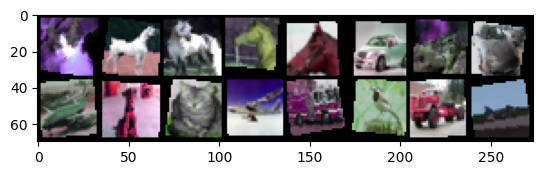

labels ['cat', 'horse', 'horse', 'horse', 'horse', 'car', 'frog', 'car', 'plane', 'dog']


In [ ]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()

# get some random training images using the data loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images and labels
timshow(torchvision.utils.make_grid(images))

print(f"labels {[classes[labels[i]] for i in range(10)]}")


Computation of loss and accuracy for given dataset loader and model. This will be used for computing loss and accuracy on the test set after each training epoch.

In [ ]:
def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    n = 0    # counter for number of minibatches
    with torch.no_grad():
        for data in loader:
            images, labels = data

            #to work with gpu you will need to load data and labels to gpu
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)

            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1

            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels

    return running_loss/n, correct/total

## Define model

In [ ]:
net = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=8, kernel_size=5),    # no padding, stride=1, dilation=1 by default
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=8,out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,64),     # with 32x32 input, the feature map size reduces to 5x5 with 16 channels.
    nn.ReLU(),
    nn.Linear(64,10)
)

for param in net.parameters():
    print(param.shape)


torch.Size([8, 3, 5, 5])
torch.Size([8])
torch.Size([16, 8, 5, 5])
torch.Size([16])
torch.Size([64, 400])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


## Train model

In [ ]:
nepochs = 50

# create directory to save your checkpoints
results_path = ROOT+'results/'
os.makedirs(results_path, exist_ok = True)
saveCkpt = results_path+ 'cnnclassifier50epochs.pt'

statsrec = np.zeros((4,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#to work with gpu you will need to load data and labels to gpu
net = net.to(device)

for epoch in range(nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches
    for data in train_loader:
        inputs, labels = data

        #to work with gpu you will need to load data and labels to gpu
        inputs = inputs.to(device)
        labels = labels.to(device)

         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = net(inputs) # note: .to(device) helps to load data to your gpu
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # accumulate loss
        running_loss += loss.item()
        n += 1

        # accumulate data for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # add in the number of labels in this minibatch
        correct += (predicted == labels).sum().item()  # add in the number of correct labels

    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total
    ltst, atst = stats(test_loader, net)

    ltst = ltst.item() #item() moves the tensor data with 1 element to CPU

    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

# save network parameters, losses and accuracy
torch.save({"state_dict": net.state_dict(), "stats": statsrec}, saveCkpt)

epoch: 0 training loss:  2.193 training accuracy:  17.2%  test loss:  1.926 test accuracy:  30.4%
epoch: 1 training loss:  1.842 training accuracy:  33.1%  test loss:  1.598 test accuracy:  42.0%
epoch: 2 training loss:  1.655 training accuracy:  40.0%  test loss:  1.467 test accuracy:  46.5%
epoch: 3 training loss:  1.574 training accuracy:  43.2%  test loss:  1.394 test accuracy:  50.3%
epoch: 4 training loss:  1.518 training accuracy:  45.3%  test loss:  1.350 test accuracy:  51.8%
epoch: 5 training loss:  1.474 training accuracy:  47.2%  test loss:  1.328 test accuracy:  52.8%
epoch: 6 training loss:  1.447 training accuracy:  48.6%  test loss:  1.303 test accuracy:  53.0%
epoch: 7 training loss:  1.421 training accuracy:  49.5%  test loss:  1.269 test accuracy:  54.0%
epoch: 8 training loss:  1.391 training accuracy:  50.4%  test loss:  1.240 test accuracy:  55.3%
epoch: 9 training loss:  1.370 training accuracy:  51.3%  test loss:  1.206 test accuracy:  56.2%
epoch: 10 training l

Plot loss and accuracy on training and test sets

In [ ]:
results_path = ROOT+'results/cnnclassifier50epochs.pt'
data = torch.load(results_path, map_location=device) # by doing map_location=device, you can use trained model on GPU --> to test on CPU
statsrec = data["stats"]
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'test loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss, and test accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'test accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("roc.svg")
plt.show()